# Week 3: Divergence and vorticity
### MAQ - 32806, Chiel van Heerwaarden & Imme Benedict, 2016
In this assignment you will investigate whether the large-scale flow is in geostrophic and thermal wind balance. For this, you will use ECMWF ERA-Interim data from the 1st of January 2016 0:00.
___

In [19]:
import numpy as np              # Numpy is the fundamental package for scientific computing in Python.
import netCDF4 as nc            # NetCDF is the data format of the meteorological data that we use.
import matplotlib.pyplot as pl  # Matplotlib is a scientific plotting package.
from mpl_toolkits.basemap import Basemap # Import the map plotting interface.
from ipywidgets import interact
#import warnings
#warnings.filterwarnings('ignore')

___
### Understanding divergence, vorticity and deformation

Before studying weather data, you will first study the two-dimensional flow patterns associated with divergence $\dfrac{\partial u}{\partial x} + \dfrac{\partial v}{\partial y}$, vorticity $\dfrac{\partial v}{\partial x} - \dfrac{\partial u}{\partial y}$, and the two components of deformation $\dfrac{\partial u}{\partial x} - \dfrac{\partial v}{\partial y}$ and $\dfrac{\partial v}{\partial x} + \dfrac{\partial u}{\partial y}$. Every infinitisimal velocity field can be described as a linear combination of these four.

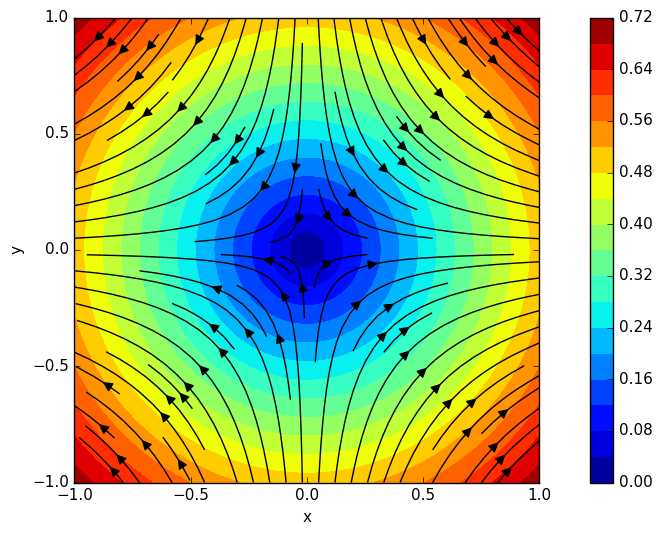

In [20]:
def plot_streamlines(div=0, zeta=0, d1=0, d2=0):
    n = 65
    x = np.linspace(-1., 1., n)
    y = np.linspace(-1., 1., n)
    u = 0.5*(div +d1)*x[np.newaxis, :] + 0.5*(d2 -zeta)*y[:,np.newaxis]
    v = 0.5*(zeta+d2)*x[np.newaxis, :] + 0.5*(div-d1  )*y[:,np.newaxis]
    U = (u**2 + v**2)**.5

    pl.subplot(111, aspect='equal')
    pl.contourf(x, y, U, 21)
    pl.colorbar()
    pl.streamplot(x, y, u, v, color='k', arrowsize=2.)
    pl.xlabel('x')
    pl.ylabel('y')
    pl.show()
    
#interact(plot_streamlines,
#         div=(-1,1,0.1), zeta=(-1,1,0.1), d1=(-1,1,0.1), d2=(-1,1,0.1));

plot_streamlines(0,0,1,0)

___
### Setting up a Python Basemap and read out 3D fields
We start the tutorial by loading the required Python packages and setting the figure properties.

In [3]:
import numpy as np              # Numpy is the fundamental package for scientific computing in Python.
import netCDF4 as nc            # NetCDF is the data format of the meteorological data that we use.
import matplotlib.pyplot as pl  # Matplotlib is a scientific plotting package.
from mpl_toolkits.basemap import Basemap # Import the map plotting interface.
import warnings
warnings.filterwarnings('ignore')

# The statement below enforces the plots to be put into this notebook, instead of in their own windows.
%matplotlib inline
pl.rcParams.update({'font.size': 11})          # Set the standard font size of the plots to 11pt.
pl.rcParams.update({'figure.figsize': [13,6]}) # Set the standard figure size.

___
With the code below, you initialize the world map with the desired coordinates.

In [4]:
# We define a map of the northern hemisphere that is stored in the m object.
lon_start = - 50.
lon_end   =   40.
lat_start =   30.
lat_end   =   60.
m = Basemap(llcrnrlon=lon_start,
            llcrnrlat=lat_start,
            urcrnrlon=lon_end,
            urcrnrlat=lat_end,
            projection='mill', resolution='l')

___
Now, you load the data and read out the desired variables from a NetCDF file from the ECMWF ERA-Interim data archive.

In [5]:
nc_file = nc.Dataset("data/era_data.nc", "r")
#nc_file = nc.Dataset("data/era5_data.nc", "r")
lat = nc_file.variables["latitude"][:]
lon = nc_file.variables["longitude"][:]
p = nc_file.variables["level"][:]*100.
t = 0
nroll = lon.size//2
lon = np.roll(lon, nroll)
lon = np.where(lon>=180., lon-360., lon)

u     = np.roll(nc_file.variables["u"][t,:,:,:], nroll, -1)
v     = np.roll(nc_file.variables["v"][t,:,:,:], nroll, -1)
omega = np.roll(nc_file.variables["w"][t,:,:,:], nroll, -1)
Phi   = np.roll(nc_file.variables["z"][t,:,:,:], nroll, -1)
T     = np.roll(nc_file.variables["t"][t,:,:,:], nroll, -1)

nc_file.close()

lons, lats = m(*np.meshgrid(lon, lat))
lonrad, latrad = np.meshgrid(np.pi/180.*lon, np.pi/180.*lat)

___
### Plotting the temperature, geopotential and wind vectors
As a starting point you find below the temperature and geopotential at 500 hPa.

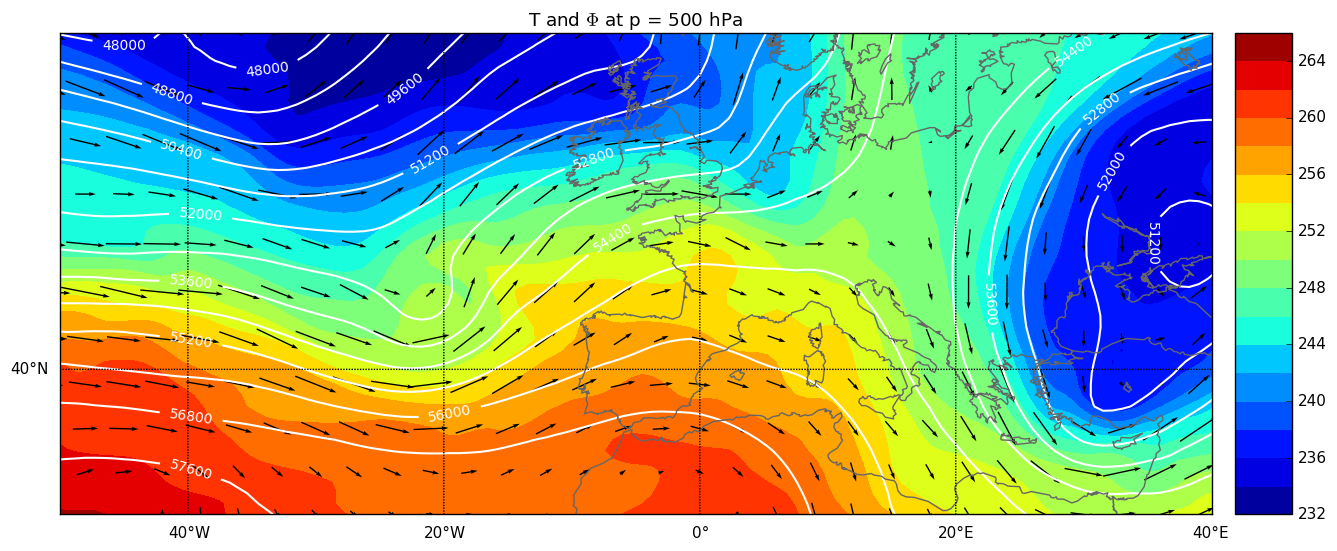

In [6]:
p_plot = 50000.
n = abs(p-p_plot).argmin()
nq = 4 # In the quiver plot we take steps of nq, otherwise there are too many arrows.

m.contourf(lons, lats, T[n,:,:], 20, cmap=pl.cm.jet)
m.colorbar()
qu = m.quiver(lons[::nq,::nq], lats[::nq,::nq],
              u[n,::nq,::nq], v[n,::nq, ::nq],
              pivot='mid', width=1.2e-3,
              scale=1000.)

cz = m.contour(lons, lats, Phi[n,:,:], 15, colors='w', linewidths=1.5)
pl.clabel(cz, fontsize=10., fmt='%1.0f')
m.drawcoastlines(color='#666666')
# draw parallels.
parallels = np.arange(-80.,90,20.)
m.drawparallels(parallels,labels=[1,0,0,0])
# draw meridians
meridians = np.arange(0.,360.,20.)
m.drawmeridians(meridians,labels=[0,0,0,1])
pl.title('T and $\Phi$ at p = {0:.0f} hPa'.format(p[n] / 100));
pl.tight_layout()

In [7]:
a = 6.37e6
dudx = 1./(a * np.cos(latrad)) * np.gradient(u, axis=2) / np.gradient(lonrad, axis=1)
dvdy = 1./(a * np.cos(latrad)) * np.gradient(v*np.cos(latrad), axis=1) \
                               / np.gradient(latrad, axis=0)
divh = dudx + dvdy

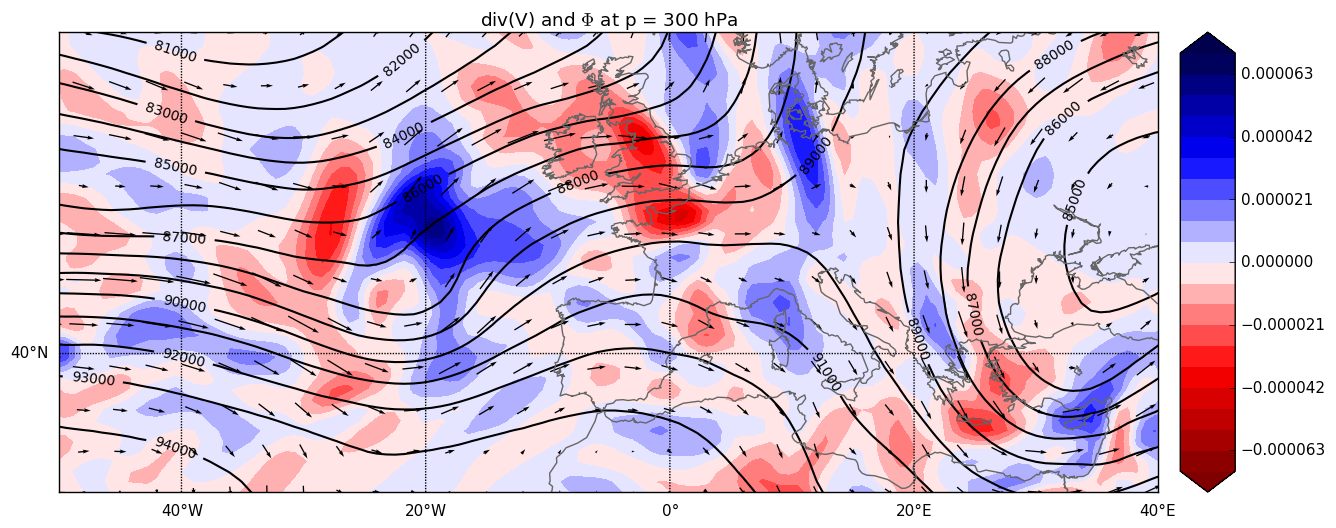

In [8]:
p_plot = 30000.
n = abs(p-p_plot).argmin()
nq = 4 # In the quiver plot we take steps of nq, otherwise there are too many arrows.

div_range = np.linspace(-7e-5, 7e-5, 21)

m.contourf(lons, lats, divh[n,:,:], div_range, cmap=pl.cm.seismic_r, extend='both')
m.colorbar()
qu = m.quiver(lons[::nq,::nq], lats[::nq,::nq],
              u[n,::nq,::nq], v[n,::nq, ::nq],
              pivot='mid', width=1.2e-3,
              scale=2000.)

cz = m.contour(lons, lats, Phi[n,:,:], 15, colors='k', linewidths=1.5)
pl.clabel(cz, fontsize=10., fmt='%1.0f')
m.drawcoastlines(color='#666666')
# draw parallels.
parallels = np.arange(-80.,90,20.)
m.drawparallels(parallels,labels=[1,0,0,0])
# draw meridians
meridians = np.arange(0.,360.,20.)
m.drawmeridians(meridians,labels=[0,0,0,1])
pl.title('div(V) and $\Phi$ at p = {0:.0f} hPa'.format(p[n] / 100));
pl.tight_layout()

In [9]:
a = 6.37e6
dvdx = 1./(a * np.cos(latrad)) * np.gradient(v, axis=2) / np.gradient(lonrad, axis=1)
dudy = 1./(a * np.cos(latrad)) * np.gradient(u*np.cos(latrad), axis=1) \
                               / np.gradient(latrad, axis=0)
zeta = dvdx - dudy

Omega = 7.292e-5
f = 2.*Omega*np.sin(latrad)

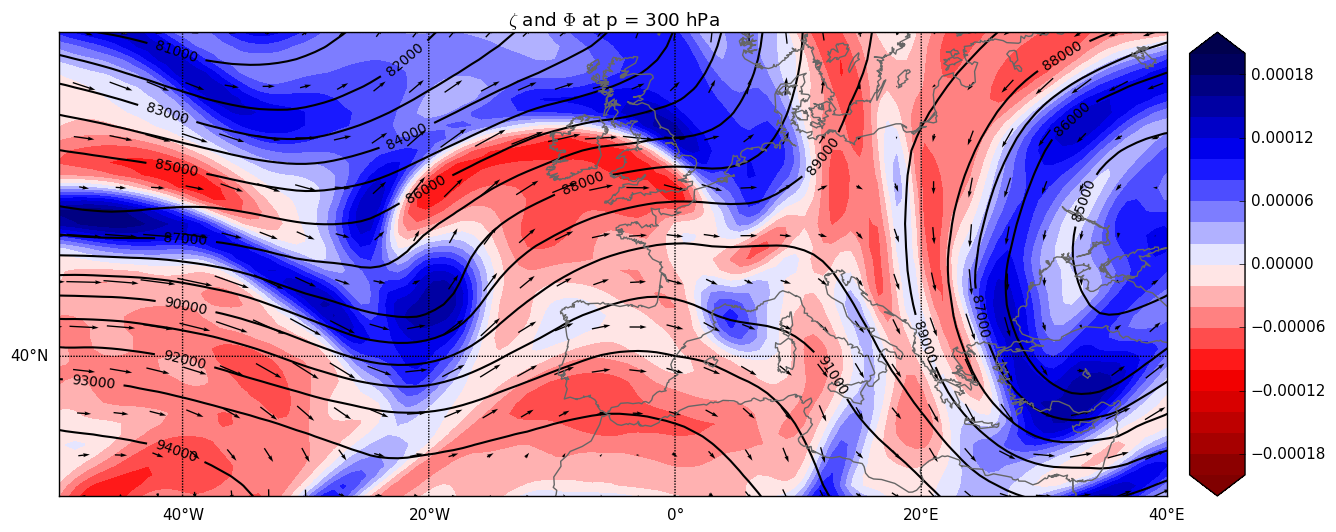

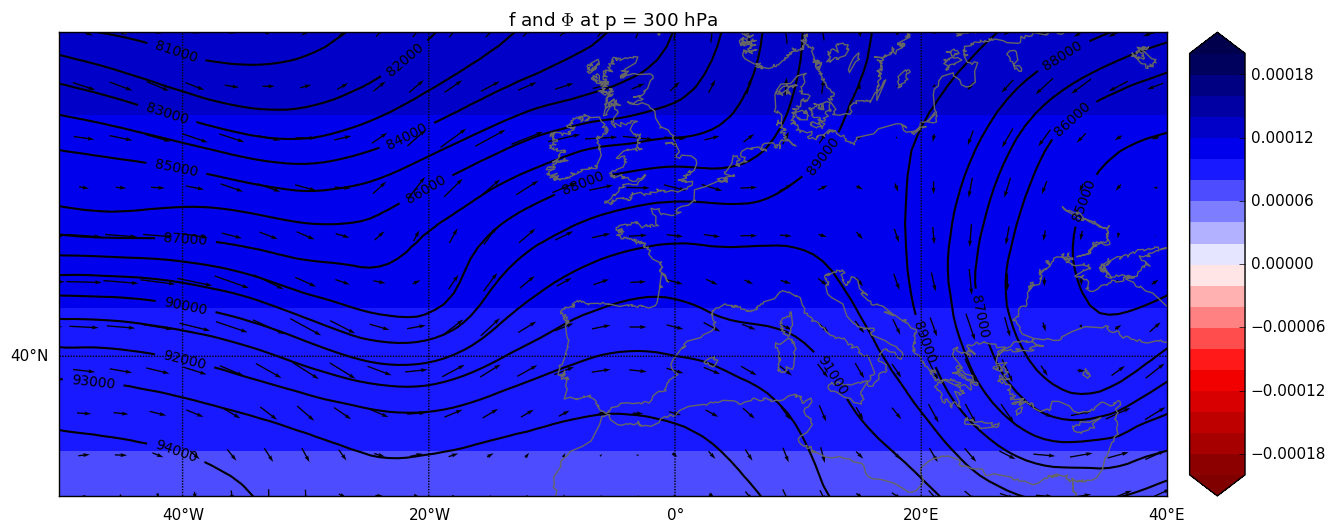

In [10]:
p_plot = 30000.
n = abs(p-p_plot).argmin()
nq = 4 # In the quiver plot we take steps of nq, otherwise there are too many arrows.

zeta_range = np.linspace(-2e-4, 2e-4, 21)

pl.figure()
m.contourf(lons, lats, zeta[n,:,:], zeta_range, cmap=pl.cm.seismic_r, extend='both')
m.colorbar()
qu = m.quiver(lons[::nq,::nq], lats[::nq,::nq],
              u[n,::nq,::nq], v[n,::nq, ::nq],
              pivot='mid', width=1.2e-3,
              scale=2000.)

cz = m.contour(lons, lats, Phi[n,:,:], 15, colors='k', linewidths=1.5)
pl.clabel(cz, fontsize=10., fmt='%1.0f')
m.drawcoastlines(color='#666666')
# draw parallels.
parallels = np.arange(-80.,90,20.)
m.drawparallels(parallels,labels=[1,0,0,0])
# draw meridians
meridians = np.arange(0.,360.,20.)
m.drawmeridians(meridians,labels=[0,0,0,1])
pl.title('$\zeta$ and $\Phi$ at p = {0:.0f} hPa'.format(p[n] / 100));
pl.tight_layout()

pl.figure()
m.contourf(lons, lats, f, zeta_range, cmap=pl.cm.seismic_r, extend='both')
m.colorbar()
qu = m.quiver(lons[::nq,::nq], lats[::nq,::nq],
              u[n,::nq,::nq], v[n,::nq, ::nq],
              pivot='mid', width=1.2e-3,
              scale=2000.)

cz = m.contour(lons, lats, Phi[n,:,:], 15, colors='k', linewidths=1.5)
pl.clabel(cz, fontsize=10., fmt='%1.0f')
m.drawcoastlines(color='#666666')
# draw parallels.
parallels = np.arange(-80.,90,20.)
m.drawparallels(parallels,labels=[1,0,0,0])
# draw meridians
meridians = np.arange(0.,360.,20.)
m.drawmeridians(meridians,labels=[0,0,0,1])
pl.title('f and $\Phi$ at p = {0:.0f} hPa'.format(p[n] / 100));
pl.tight_layout()

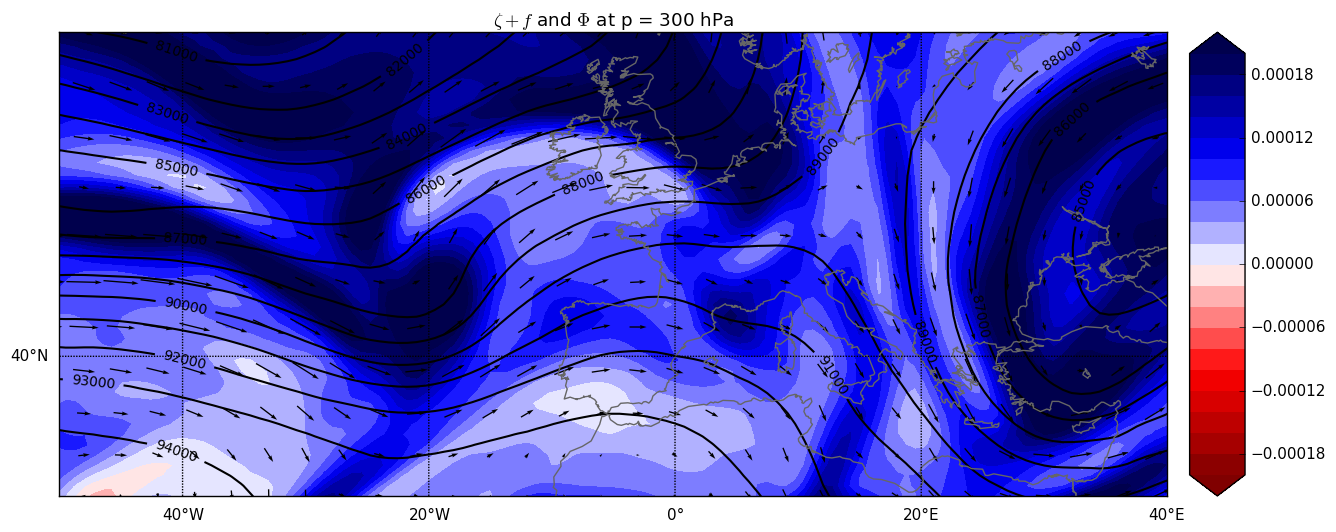

In [11]:
p_plot = 30000.
n = abs(p-p_plot).argmin()
nq = 4 # In the quiver plot we take steps of nq, otherwise there are too many arrows.

m.contourf(lons, lats, zeta[n,:,:] + f[:,:], zeta_range, cmap=pl.cm.seismic_r, extend='both')
m.colorbar()
qu = m.quiver(lons[::nq,::nq], lats[::nq,::nq],
              u[n,::nq,::nq], v[n,::nq, ::nq],
              pivot='mid', width=1.2e-3,
              scale=2000.)

cz = m.contour(lons, lats, Phi[n,:,:], 15, colors='k', linewidths=1.5)
pl.clabel(cz, fontsize=10., fmt='%1.0f')
m.drawcoastlines(color='#666666')
# draw parallels.
parallels = np.arange(-80.,90,20.)
m.drawparallels(parallels,labels=[1,0,0,0])
# draw meridians
meridians = np.arange(0.,360.,20.)
m.drawmeridians(meridians,labels=[0,0,0,1])
pl.title('$\zeta + f$ and $\Phi$ at p = {0:.0f} hPa'.format(p[n] / 100));
pl.tight_layout()

In [17]:
dzetadx = 1./(a * np.cos(latrad)) * np.gradient(zeta, axis=2) / np.gradient(lonrad, axis=1)
dzetady = 1./a * np.gradient(zeta, axis=1) / np.gradient(latrad, axis=0)
dzetadp = np.gradient(zeta, axis=0) / np.gradient(p[:, np.newaxis, np.newaxis], axis=0)
dfdy = 1./a * np.gradient(f, axis=0) / np.gradient(latrad, axis=0)

dzetadt_adv   = - u*dzetadx - v*dzetady - omega*dzetadp
dzetadt_adv_f = - v*dfdy[np.newaxis,:,:]
dzetadt_div   = - (zeta + f) * divh
dzetadt = dzetadt_adv + dzetadt_div + dzetadt_adv_f

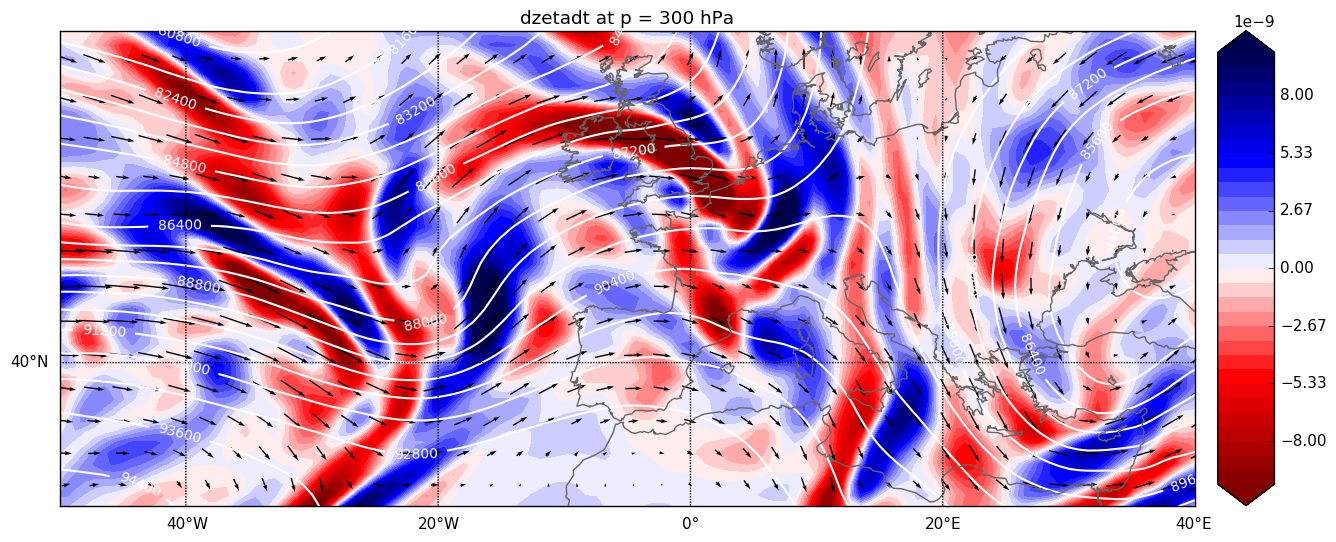

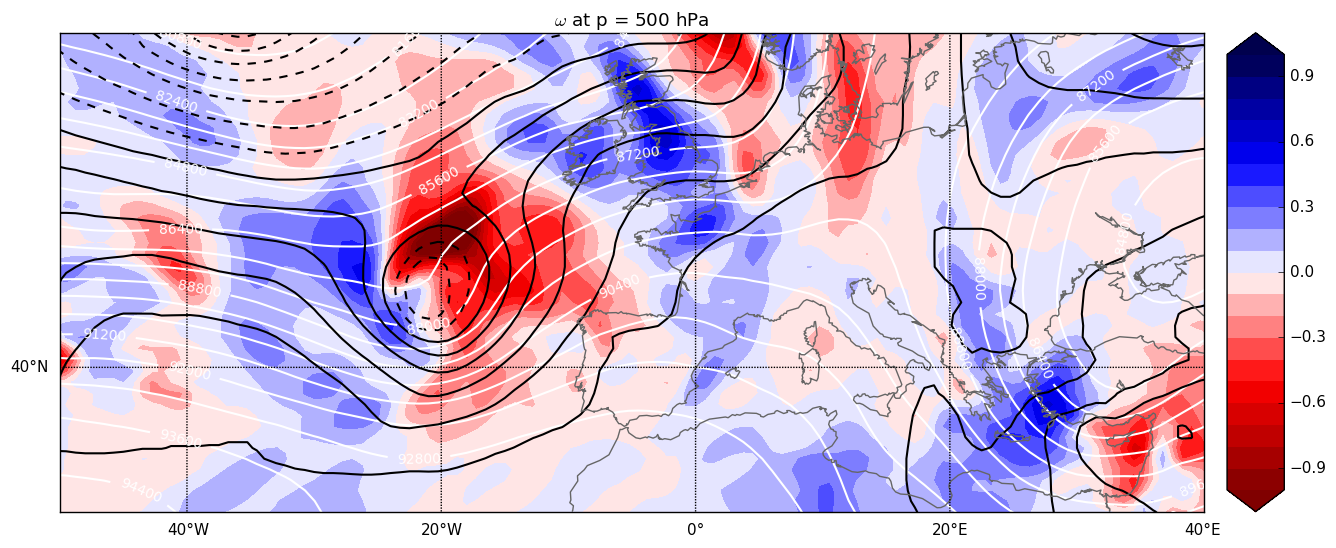

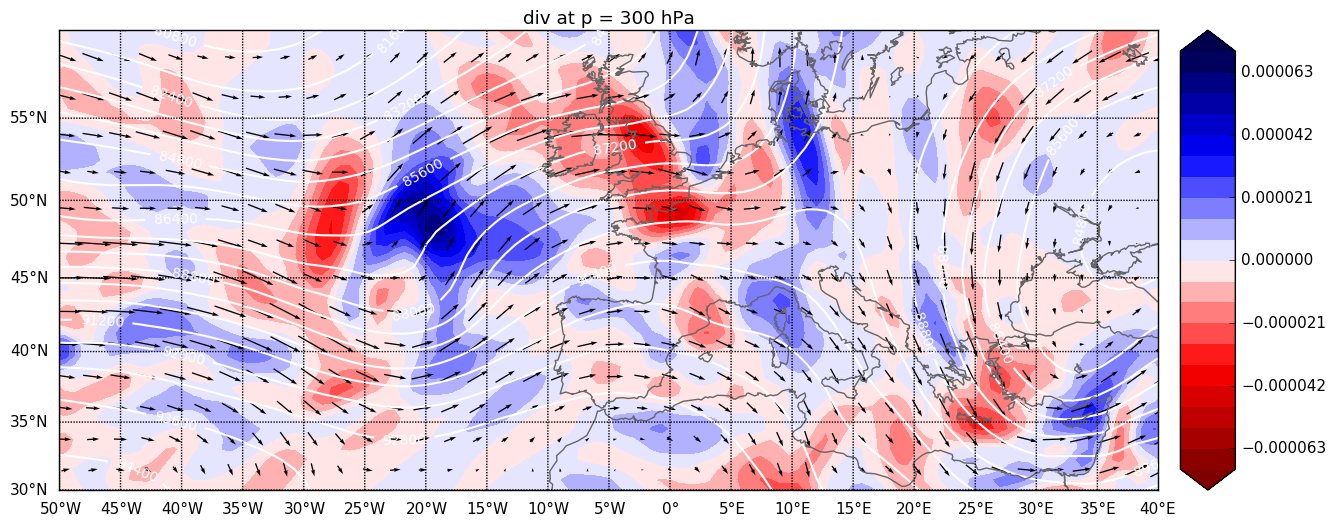

In [69]:
p_plot = 30000.
n = abs(p-p_plot).argmin()

p_plot = 50000.
n500 = abs(p-p_plot).argmin()

p_plot = 85000.
n850 = abs(p-p_plot).argmin()

p_plot = 100000.
n1000 = abs(p-p_plot).argmin()

nq = 3

dzetadt_range = np.linspace(-1e-8, 1e-8, 31)

m.contourf(lons, lats, dzetadt[n,:,:], dzetadt_range,
           cmap=pl.cm.seismic_r, extend='both')
m.colorbar()
qu = m.quiver(lons[::nq,::nq], lats[::nq,::nq],
              u[n,::nq,::nq], v[n,::nq, ::nq],
              pivot='mid', width=1.2e-3,
              scale=2000.)

cz = m.contour(lons, lats, Phi[n,:,:], 21, colors='w', linewidths=1.5)
pl.clabel(cz, fontsize=10., fmt='%1.0f')
m.drawcoastlines(color='#666666')
# draw parallels.
parallels = np.arange(-80.,90,20.)
m.drawparallels(parallels,labels=[1,0,0,0])
# draw meridians
meridians = np.arange(0.,360.,20.)
m.drawmeridians(meridians,labels=[0,0,0,1])
pl.title('dzetadt at p = {0:.0f} hPa'.format(p[n] / 100));
pl.tight_layout()

omega_scale = np.linspace(-1., 1., 21)
pl.figure()
m.contourf(lons, lats, omega[n500,:,:], omega_scale,
           cmap=pl.cm.seismic_r, extend='both')
m.colorbar()
#qu = m.quiver(lons[::nq,::nq], lats[::nq,::nq],
#              u[n,::nq,::nq], v[n,::nq, ::nq],
#              pivot='mid', width=1.2e-3,
#              scale=2000.)

cz = m.contour(lons, lats, Phi[n,:,:], 21, colors='w', linewidths=1.5)
pl.clabel(cz, fontsize=10., fmt='%1.0f')

cz = m.contour(lons, lats, Phi[n1000,:,:], 21, colors='k', linewidths=1.5)

m.drawcoastlines(color='#666666')
# draw parallels.
parallels = np.arange(-80.,90,20.)
m.drawparallels(parallels,labels=[1,0,0,0])
# draw meridians
meridians = np.arange(0.,360.,20.)
m.drawmeridians(meridians,labels=[0,0,0,1])
pl.title('$\omega$ at p = {0:.0f} hPa'.format(p[n500] / 100));
pl.tight_layout()

pl.figure()
m.contourf(lons, lats, divh[n,:,:], div_range,
           cmap=pl.cm.seismic_r, extend='both')
m.colorbar()
qu = m.quiver(lons[::nq,::nq], lats[::nq,::nq],
              u[n,::nq,::nq], v[n,::nq, ::nq],
              pivot='mid', width=1.2e-3,
              scale=2000.)

cz = m.contour(lons, lats, Phi[n,:,:], 21, colors='w', linewidths=1.5)
pl.clabel(cz, fontsize=10., fmt='%1.0f')
m.drawcoastlines(color='#666666')
# draw parallels.
parallels = np.arange(-80.,90,5.)
m.drawparallels(parallels,labels=[1,0,0,0])
# draw meridians
meridians = np.arange(0.,360.,5.)
m.drawmeridians(meridians,labels=[0,0,0,1])
pl.title('div at p = {0:.0f} hPa'.format(p[n] / 100));
pl.tight_layout()

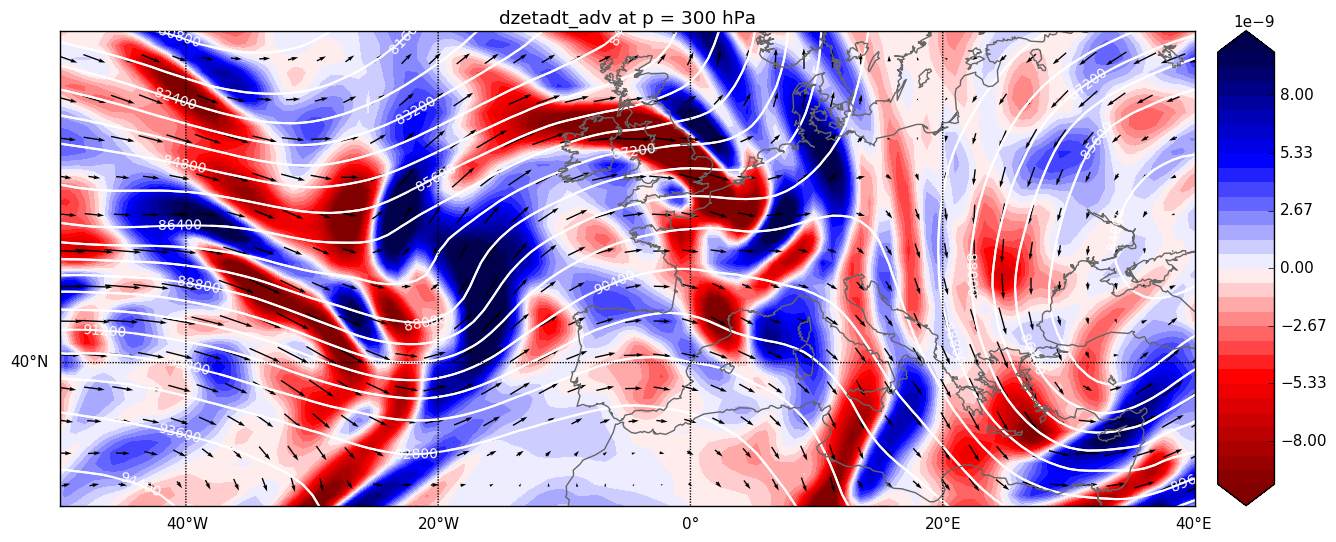

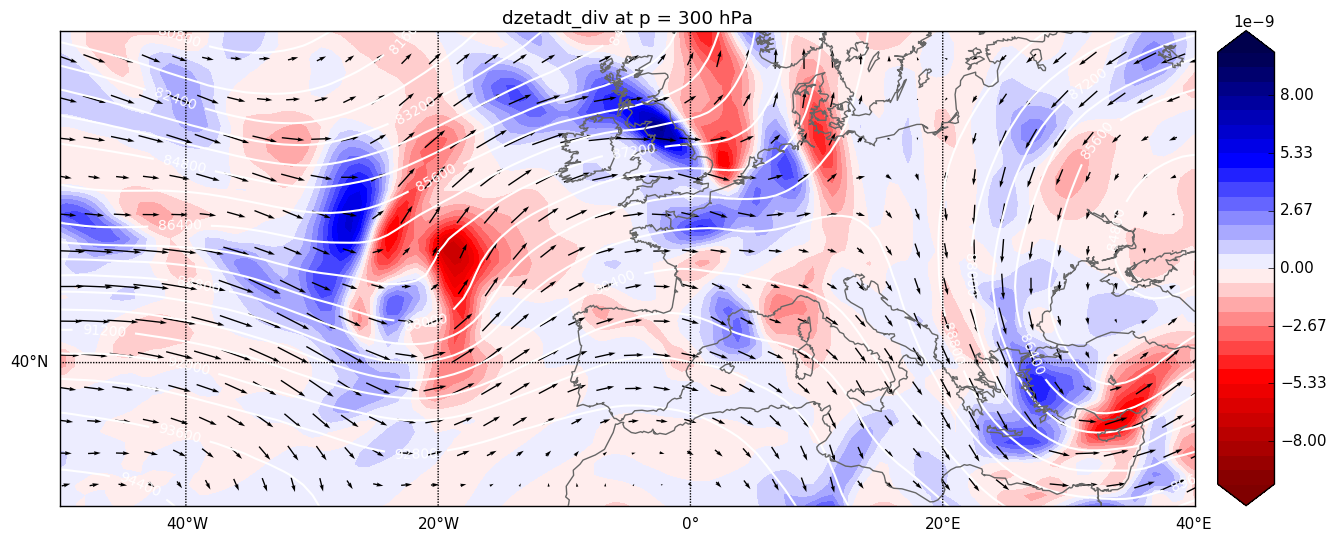

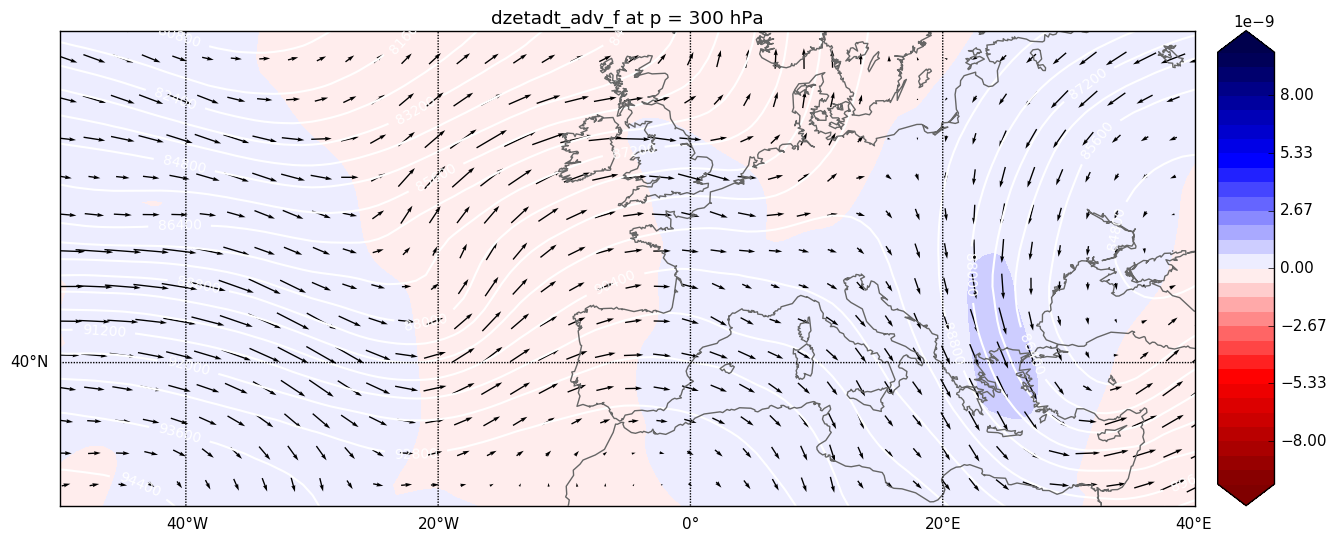

In [14]:
pl.figure()
m.contourf(lons, lats, dzetadt_adv[n,:,:], dzetadt_range,
           cmap=pl.cm.seismic_r, extend='both')
m.colorbar()
qu = m.quiver(lons[::nq,::nq], lats[::nq,::nq],
              u[n,::nq,::nq], v[n,::nq, ::nq],
              pivot='mid', width=1.2e-3,
              scale=2000.)

cz = m.contour(lons, lats, Phi[n,:,:], 21, colors='w', linewidths=1.5)
pl.clabel(cz, fontsize=10., fmt='%1.0f')
cz = m.contour(lons, lats, Phi[n,:,:], 21, colors='w', linewidths=1.5)


m.drawcoastlines(color='#666666')
# draw parallels.
parallels = np.arange(-80.,90,20.)
m.drawparallels(parallels,labels=[1,0,0,0])
# draw meridians
meridians = np.arange(0.,360.,20.)
m.drawmeridians(meridians,labels=[0,0,0,1])
pl.title('dzetadt_adv at p = {0:.0f} hPa'.format(p[n] / 100));
pl.tight_layout()

pl.figure()
m.contourf(lons, lats, dzetadt_div[n,:,:], dzetadt_range,
           cmap=pl.cm.seismic_r, extend='both')
m.colorbar()
qu = m.quiver(lons[::nq,::nq], lats[::nq,::nq],
              u[n,::nq,::nq], v[n,::nq, ::nq],
              pivot='mid', width=1.2e-3,
              scale=2000.)

cz = m.contour(lons, lats, Phi[n,:,:], 21, colors='w', linewidths=1.5)
pl.clabel(cz, fontsize=10., fmt='%1.0f')
m.drawcoastlines(color='#666666')
# draw parallels.
parallels = np.arange(-80.,90,20.)
m.drawparallels(parallels,labels=[1,0,0,0])
# draw meridians
meridians = np.arange(0.,360.,20.)
m.drawmeridians(meridians,labels=[0,0,0,1])
pl.title('dzetadt_div at p = {0:.0f} hPa'.format(p[n] / 100));
pl.tight_layout()

pl.figure()
m.contourf(lons, lats, dzetadt_adv_f[n,:,:], dzetadt_range,
           cmap=pl.cm.seismic_r, extend='both')
m.colorbar()
qu = m.quiver(lons[::nq,::nq], lats[::nq,::nq],
              u[n,::nq,::nq], v[n,::nq, ::nq],
              pivot='mid', width=1.2e-3,
              scale=2000.)

cz = m.contour(lons, lats, Phi[n,:,:], 21, colors='w', linewidths=1.5)
pl.clabel(cz, fontsize=10., fmt='%1.0f')
m.drawcoastlines(color='#666666')
# draw parallels.
parallels = np.arange(-80.,90,20.)
m.drawparallels(parallels,labels=[1,0,0,0])
# draw meridians
meridians = np.arange(0.,360.,20.)
m.drawmeridians(meridians,labels=[0,0,0,1])
pl.title('dzetadt_adv_f at p = {0:.0f} hPa'.format(p[n] / 100));
pl.tight_layout()

In [15]:
dzetadt_adv_zonal   = dzetadt_adv.mean(axis=2)
dzetadt_adv_f_zonal = dzetadt_adv_f.mean(axis=2)
dzetadt_div_zonal   = dzetadt_div.mean(axis=2)

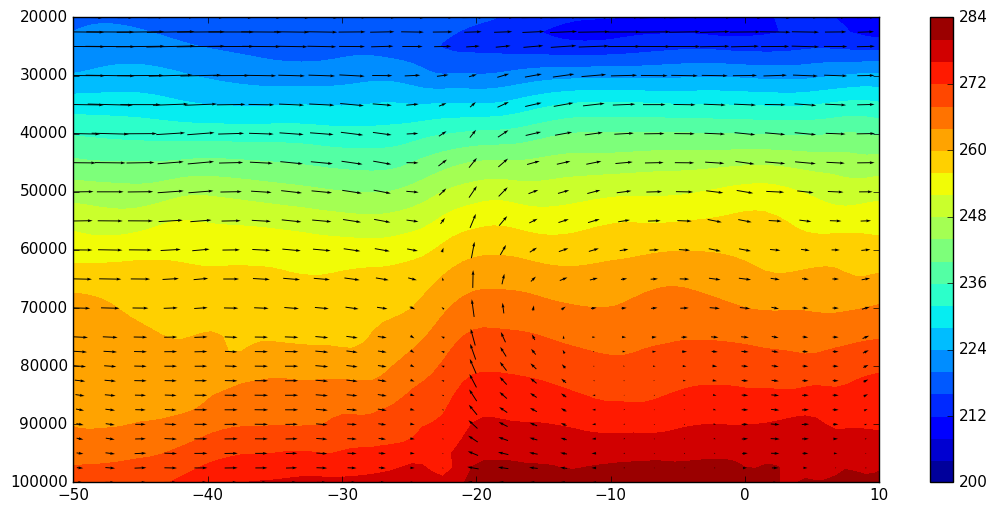

In [61]:
lat_plot = 48.
j_lat = abs(lat - lat_plot).argmin()

lonp, pp = np.meshgrid(lon, p)
pl.contourf(lon, p, T[:,j_lat,:], 21)
pl.colorbar()
pl.quiver(lonp[:,::nq], pp[:,::nq], u[:,j_lat,::nq], -10*omega[:,j_lat,::nq], 
          pivot='mid', width=1.2e-3, scale=1000)
pl.gca().invert_yaxis()
pl.xlim(-50, 10)
pl.ylim(100000, 20000);

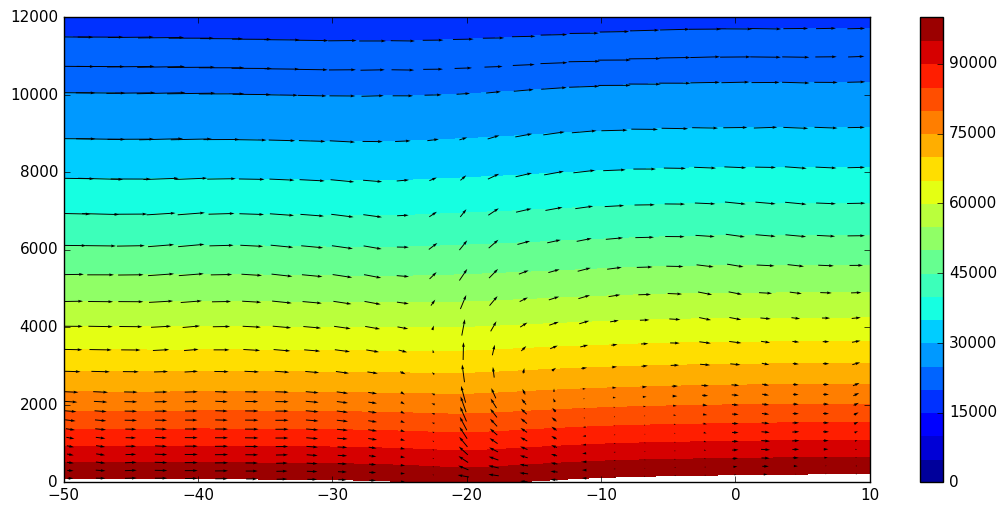

In [67]:
lonp, pp = np.meshgrid(lon, p)
pl.contourf(lonp, Phi[:,j_lat,:]/9.81, pp, 21)
pl.colorbar()
pl.quiver(lonp[:,::nq], Phi[:,j_lat,::nq]/9.81, u[:,j_lat,::nq], -10*omega[:,j_lat,::nq], 
          pivot='mid', width=1.2e-3, scale=1000)
pl.xlim(-50, 10)
pl.ylim(0, 12000);